In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")
df = pd.read_excel('train_data_classifier1.xlsx')

In [3]:
df.head()

,Unnamed: 0,essay no.,sentence,has_argument,type
0,0,1,Should students be taught to compete or to coo...,False,-
1,1,1,It is always said that competition can effecti...,False,-
2,2,1,"In order to survive in the competition, compa...",False,-
3,3,1,"However, when we discuss the issue of competi...",False,-
4,4,1,"From this point of view, I firmly believe tha...",True,MajorClaim


In [4]:
for i in range(len(df['has_argument'])):
    if df.iloc[i,3] == True :
        df.iloc[i,3] = 1
    else :
        df.iloc[i,3] = 0
        

In [5]:
df.head()

,Unnamed: 0,essay no.,sentence,has_argument,type
0,0,1,Should students be taught to compete or to coo...,0,-
1,1,1,It is always said that competition can effecti...,0,-
2,2,1,"In order to survive in the competition, compa...",0,-
3,3,1,"However, when we discuss the issue of competi...",0,-
4,4,1,"From this point of view, I firmly believe tha...",1,MajorClaim


In [6]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [7]:
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [8]:
train_text,train_labels = df['sentence'],df['has_argument']

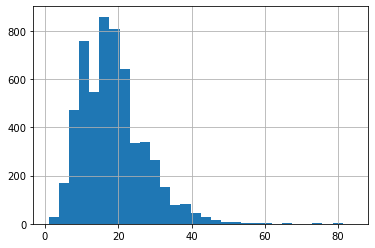

In [9]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [10]:
dff = pd.read_excel('test_data_classifier1.xlsx')
for i in range(len(dff['has_argument'])):
    if dff.iloc[i,3] == True :
        dff.iloc[i,3] = 1
    else :
        dff.iloc[i,3] = 0
traintext, temp_text, trainlabels, temp_labels = train_test_split(dff['sentence'], dff['has_argument'], 
                                                                    random_state=2018, 
                                                                    test_size=0.9, 
                                                                    stratify=dff['has_argument'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 40,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 40,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 40,
    pad_to_max_length=True,
    truncation=True
)

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [14]:
for param in bert.parameters():
    param.requires_grad = False

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [16]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [17]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)   

In [18]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [2.17978395 0.64882866]


/home/parth/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0 1], y=0       0
1       0
2       0
3       0
4       1
       ..
5645    1
5646    1
5647    1
5648    1
5649    1
Name: has_argument, Length: 5650, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [19]:
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [20]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [22]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  of    177.

Evaluating...

Training Loss: 0.684
Validation Loss: 0.668

 Epoch 2 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  of    177.

Evaluating...

Training Loss: 0.661
Validation Loss: 0.651

 Epoch 3 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  of    177.

Evaluating...

Training Loss: 0.648
Validation Loss: 0.640

 Epoch 4 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  of    177.

Evaluating...

Training Loss: 0.634
Validation Loss: 0.630

 Epoch 5 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  of    177.

Evaluating...

Training Loss: 0.628
Validation Loss: 0.626

 Epoch 6 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  of    177.

Evaluating...

Training Loss: 0.625
Validation Loss: 0.619

 Epoch 7 / 10
  Batch    50  of    177.
  Batch   100  of    177.
  Batch   150  

In [23]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [24]:
psd = pd.read_csv('data.csv')
from tqdm import tqdm
predictions_final = []
for j in tqdm(range(len(psd['Corpus']))):
  sentences = []
  text = str(psd['Corpus'][j])
  sent_list = text.split('.')
  for j in sent_list :
    sentences.append(j)
  df = pd.DataFrame(sentences, columns =['Sentences']) 
  sentf_list = df['Sentences']
  tokens_train = tokenizer.batch_encode_plus(
    sentf_list.tolist(),
    max_length = 250,
    pad_to_max_length=True,
    truncation=True
)
  train_seq = torch.tensor(tokens_train['input_ids'])
  train_mask = torch.tensor(tokens_train['attention_mask'])
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  predictions_final.append(preds)

  0%|          | 0/32125 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 304.00 MiB (GPU 0; 1.96 GiB total capacity; 959.56 MiB already allocated; 87.81 MiB free; 1.43 GiB reserved in total by PyTorch)

In [ ]:
import csv
with open('outputFile.csv', 'w', newline='') as csvfile:
  for j in range(len(psd['Corpus'])):
    writer = csv.writer(csvfile, delimiter=',')
    final_list = []
    text = str(psd['Corpus'][j])
    sent_list = text.split('.')
    for k in range(len(sent_list)):
      if predictions_final[j][k] == 1 :
        final_list.append(sent_list[k])
    writer.writerow(final_list)